## **Dynamic Risk Budgeting**

In [8]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from risk_kit import Metrics, pre_processing_ind, get_ind30_nfirms,\
                    get_ind30_size, plot_ef2, fixedmix_allocator, glidepath_allocator, floor_allocator, drawdown_allocator
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.6f}'.format

m = Metrics()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_scenarios = 5000
rates, zc_prices = m.cir(n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = m.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_zc = zc_prices.pct_change().dropna()
rets_eq = price_eq.pct_change().dropna()

In [3]:
# let's use a ZC Bond as a proxy for a duration matched portfolio (it can be simulated with
# the composition of coupon-paying bonds that matches our liaibilities)
rets_floor75 = m.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:])
rets_7030b = m.bt_mix(rets_eq, rets_zc, allocator=fixedmix_allocator, w1=0.7)

pd.concat([m.terminal_stats(rets_zc, name="ZC", floor=0.75),
           m.terminal_stats(rets_eq, name="Eq", floor=0.75),
           m.terminal_stats(rets_7030b, name="70/30", floor=0.75), # for comparison
           m.terminal_stats(rets_floor75, name="Floor75", floor=0.75)
          ], axis=1)

,ZC,Eq,70/30,Floor75
mean,1.343337,1.975784,1.760446,1.952523
std,0.000000,0.983725,0.597790,0.988122
p_breach,NaN,0.036200,0.009800,NaN
e_short,NaN,0.128889,0.080545,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


COMMENT: let's try to fix the breaches of these naive approaches. They are happening since these naive allocators don't take into account the floor. By considering a more realistic allocator: namely the "floor allocator", it does exactly this job (0 or very few violations). They trade-off some upside in exchange for a cut in the downside. In this case violations are zero since we are rebalancing every single month.

In [5]:
# with m=1 we only put the cushion in the PSP. In this case we are 100% sure that no violations occur
rets_floor75m1 = m.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=1)
# with m=5 we are completely on the risk side
rets_floor75m5 = m.bt_mix(rets_eq, rets_zc, allocator=floor_allocator, floor=0.75, zc_prices=zc_prices[1:], m=7)
pd.concat([m.terminal_stats(rets_zc, name="ZC", floor=0.75),
           m.terminal_stats(rets_eq, name="Eq", floor=0.75),
           m.terminal_stats(rets_7030b, name="70/30", floor=0.75), # for comparison
           m.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           m.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           m.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
          ], axis=1)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5
mean,1.343337,1.975784,1.760446,1.952523,1.624557,1.964349
std,0.000000,0.983725,0.597790,0.988122,0.434140,0.990940
p_breach,NaN,0.036200,0.009800,NaN,NaN,0.005000
e_short,NaN,0.128889,0.080545,NaN,NaN,0.002673
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


Let's use the drawdown allocator. The interesting thing there is that you don't have a distinct liability since at any point in time you don't want to be less than the acceptable drawdown. This is equivalent to having a very short-term liability (duration of cash is zero) constraint rather than a fixed floor constraint.

In [9]:
# risk budgeting with DrawDown constraints
# here we don't use ZC Bonds since it drop prices at some points in time.
# We need something that have  avery short duration

cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
# I am using cash as safe asset. In other cases we may use S&P500 as a safe asset.
# The bt_mix doesn't care what you use as safe asset
rets_maxdd25 = m.bt_mix(rets_eq, rets_cash, allocator=drawdown_allocator, maxdd=0.25)
tw_maxdd25 = m.terminal_values(rets_maxdd25)

In [10]:
pd.concat([m.terminal_stats(rets_zc, name="ZC", floor=0.75),
           m.terminal_stats(rets_eq, name="Eq", floor=0.75),
           m.terminal_stats(rets_7030b, name="70/30", floor=0.75), # for comparison
           m.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           m.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           m.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
            m.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75),
          ], axis=1)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.343337,1.975784,1.760446,1.952523,1.624557,1.964349,1.630910
std,0.000000,0.983725,0.597790,0.988122,0.434140,0.990940,0.542716
p_breach,NaN,0.036200,0.009800,NaN,NaN,0.005000,NaN
e_short,NaN,0.128889,0.080545,NaN,NaN,0.002673,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ASIDE NOTE: we run our backtester with simulated data. There is no reason why this can't be done with real data

COMMENT: the poin of using MaxDD was not to avoid breaches but to give you a different goal. How do we make sure
that we achieved the objective?

In [11]:
m.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.126438
1   -0.114710
2   -0.143720
3   -0.203140
4   -0.187660
Name: Max Drawdown, dtype: float64

In [12]:
m.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23156592027072212

In [18]:
tv_eq = m.terminal_values(rets_eq)
tv_7030b = m.terminal_values(rets_7030b)
tv_floor75 = m.terminal_values(rets_floor75)
tv_maxdd25 = m.terminal_values(rets_maxdd25)

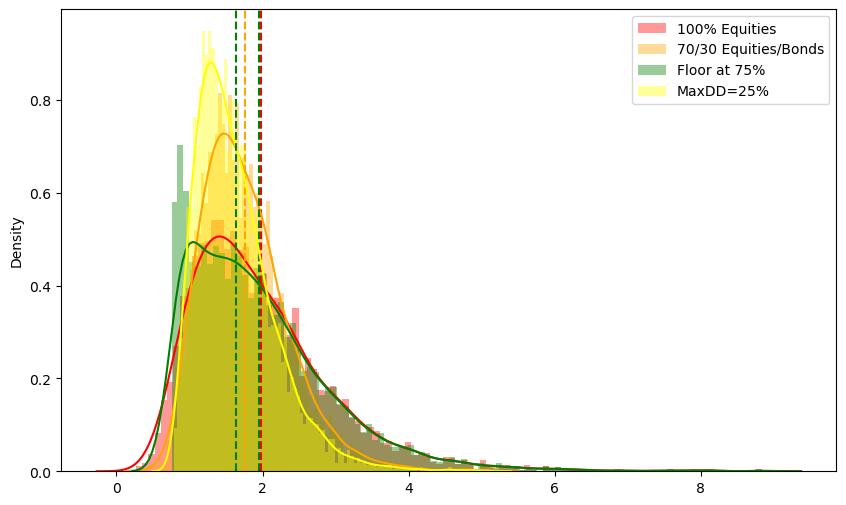

In [20]:
# PLOT time!!
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")

sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

sns.distplot(tv_maxdd25, color="yellow", label="MaxDD=25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="green")
plt.legend();

COMMENT: we can see that the "Floor75" strategy has very, very little in terms of opportunity costs
But what you get in exchange is a bimodal curve (the green one) and the expected value is still pretty decent. With the green line you've eliminated those worst cases below the floor (0.75).
Large part of how these strategies operate is in shaping, shifting the outcomes of the distribution towards something that is more acceptable to you.

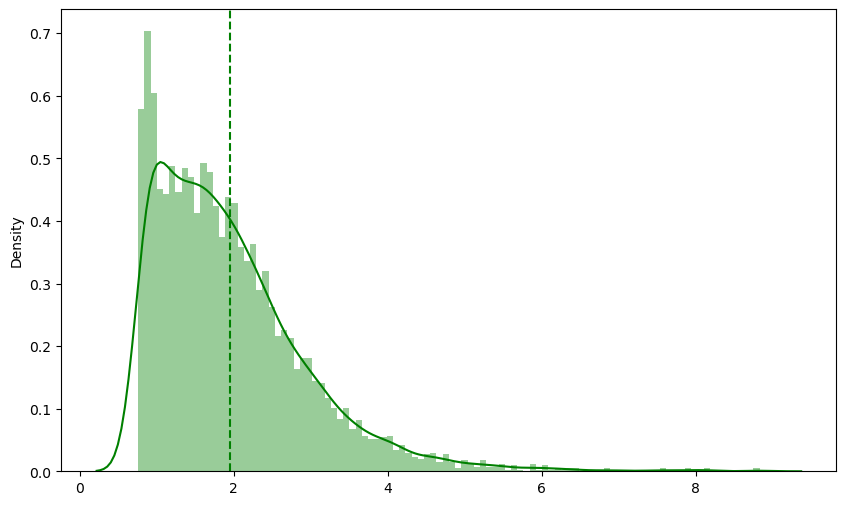

In [22]:
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green");

In [27]:
def get_ind_file(filetype):
    """
    Load and format the Ken French 30 Industry Portfolios files
    """
    known_types = ["returns", "nfirms", "size"]
    if filetype not in known_types:
        sep = ','
        raise ValueError(f'filetype must be one of:{sep.join(known_types)}')
    if filetype is "returns":
        name = "vw_rets"
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    ind = pd.read_csv(f"data/ind30_m_{name}.csv", header=0, index_col=0)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    return get_ind_file("returns")

def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms")

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size")

def get_total_market_index_returns():
    """
    Load the 30 industry portfolio data and derive the returns of a capweighted total market index
    """
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = get_ind_returns()
    ind_mktcap = ind_nfirms * ind_size
    total_mktcap = ind_mktcap.sum(axis=1)
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    return total_market_return
                         

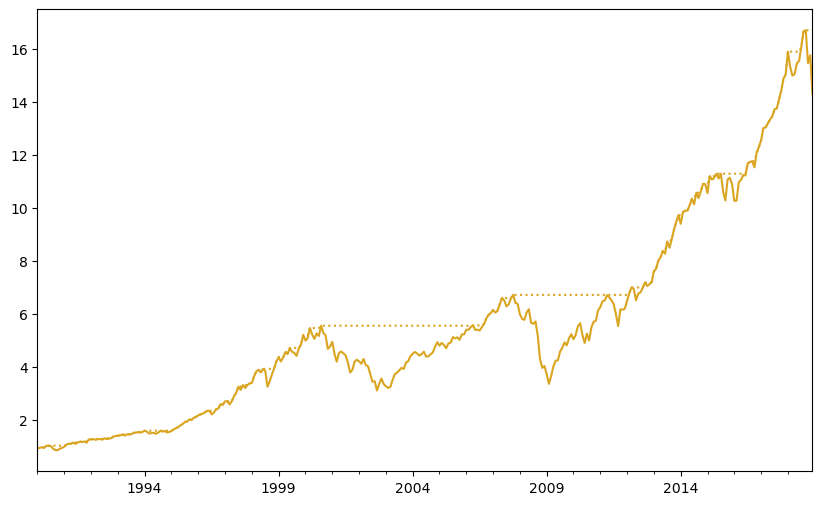

In [37]:
# let's simulate DrawDown Constraint with actual historical data
rets_tmi =  get_total_market_index_returns()["1990":]
dd_tmi = m.drawdown(rets_tmi)
ax= dd_tmi["Wealth"].plot(ls="-", color= "goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod");

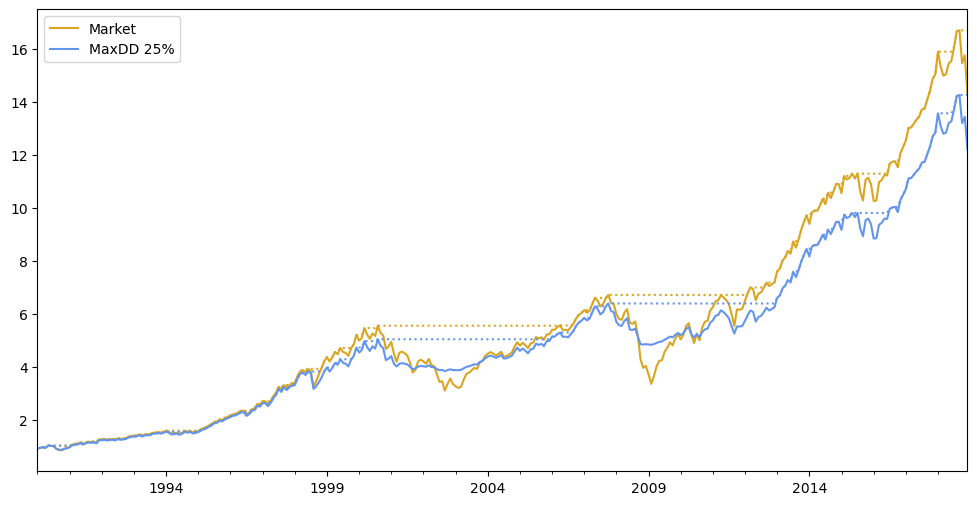

In [41]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) -1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index=rets_tmi.index, columns=[0]) # one column dataframe
rets_maxdd25 = m.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=drawdown_allocator, maxdd=0.25, m=5)
dd_25 = m.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":");

COMMENT: the simulation works well even with historical data. Here we have got only one scenario while in simulation we can get thousands of scenarios

In [43]:
m.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Ann. Return,Ann. Volatility,Skewness,Kurtosis,Corn-Fisher VaR (5%),Hist. CVar (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212


with the constrained-DrawDown version of the tmi index we respect the linit of 2%% imposed on drawdown 

CONCLUSIONS: we did talk about what is a good GHP (or LHP). We got it covered by building decent GHPs
if we know the duration of our liability. We can match the duration of our liability by contructing a portfolio
of ordimary coupon-paying bonds (treasury portfolio). We didn't really cover what constitues a good PSP. There are more sophisticated techniques at our disposal than the total market index (cap weighted portfolio) we saw in this course. We will see them in the next course.